In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (make_scorer, precision_score, recall_score, 
                             f1_score, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_auc_score)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
np.random.seed(42)

top_features = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/top_features_gpt2.csv")
df = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/df_gpt_com_features.csv")
top20_features = top_features.head(20)

X = df[top20_features['feature'].tolist()]

y = df['origin']

In [3]:
X = np.nan_to_num(X, nan=0.0)

In [8]:
lista_valores = top_features['feature'].tolist()
lista_valores

['structural_has_hashtag',
 'structural_hashtag_density',
 'lexical_word_length_variance',
 'https',
 'modi',
 'co',
 'structural_has_url',
 'structural_url_density',
 'https co',
 'structural_extra_spaces',
 'stylistic_capitalization_inconsistency',
 'complexity_long_sentences',
 'stylistic_capitalization_inconsistency.1',
 'complexity_rare_words',
 'of',
 'lexical_avg_word_length',
 'the',
 'stylistic_random_uppercase.1',
 'syntactic_pos_tag_entropy',
 'stylistic_random_uppercase',
 'is',
 'syntactic_avg_sentence_length',
 'syntactic_pos_bigram_entropy',
 'in',
 'lexical_word_count',
 'ai_topic_shifts',
 'to',
 'lexical_unique_words',
 'lexical_stopword_ratio',
 'climate',
 'climate change',
 'trump',
 'change',
 'lexical_type_token_ratio',
 'ai_perplexity_score',
 'covid',
 'science',
 'covid 19',
 'we',
 '19',
 'complexity_syntactic_depth',
 'covid19',
 'on',
 'structural_mention_density',
 'us',
 'by',
 'and',
 'the trump',
 'stylistic_exclamation_density',
 'complexity_subordinat

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
import matplotlib.pyplot as plt
import numpy as np

def random_forest_pipeline(X, y, test_size=0.2, random_state=42, n_estimators=100, cv=5):
    """
    Executa validação cruzada, treino final e plota matriz de confusão em porcentagem.
    
    Args:
        X: features
        y: labels
        test_size: tamanho do conjunto de teste
        random_state: seed
        n_estimators: número de árvores da Random Forest
        cv: número de folds para validação cruzada
    """
    
    # ==================== 1. VALIDAÇÃO CRUZADA ====================
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score)
    }
    
    results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA:")
    print("-" * 40)
    for metric in scoring.keys():
        mean_score = np.mean(results['test_' + metric])
        std_score = np.std(results['test_' + metric])
        print(f"{metric:12}: {mean_score:.4f} ± {std_score:.4f}")
    
    # ==================== 2. TREINAMENTO E MATRIZ DE CONFUSÃO ====================
    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Treinar modelo
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Previsões
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # Métricas finais
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n📈 Métricas no conjunto de teste:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # % por classe

    # Plotar
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Humano', 'IA'])
    disp.plot(cmap='Blues', values_format='.2f')
    plt.title('Matriz de Confusão - Random Forest\n(Conjunto de Teste)', fontsize=14, pad=20)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return rf_model, cm_percent, results



📊 RESULTADOS DA VALIDAÇÃO CRUZADA:
----------------------------------------
accuracy    : 0.9695 ± 0.0215
precision   : 0.9766 ± 0.0227
recall      : 0.9624 ± 0.0291
f1          : 0.9692 ± 0.0218
roc_auc     : 0.9695 ± 0.0215


📈 Métricas no conjunto de teste:
Accuracy : 0.9756
Precision: 0.9806
Recall   : 0.9703
F1-Score : 0.9754
ROC-AUC  : 0.9963

🔍 MATRIZ DE CONFUSÃO:
Verdadeiros Negativos (Humanos corretos): 19616
Falsos Positivos (Humanos → IA)        : 384
Falsos Negativos (IA → Humanos)        : 594
Verdadeiros Positivos (IA corretos)    : 19406

📊 TAXAS DE ERRO:
Humanos classificados como IA: 1.92%
IA classificada como Humanos : 2.97%


<Figure size 1000x800 with 0 Axes>

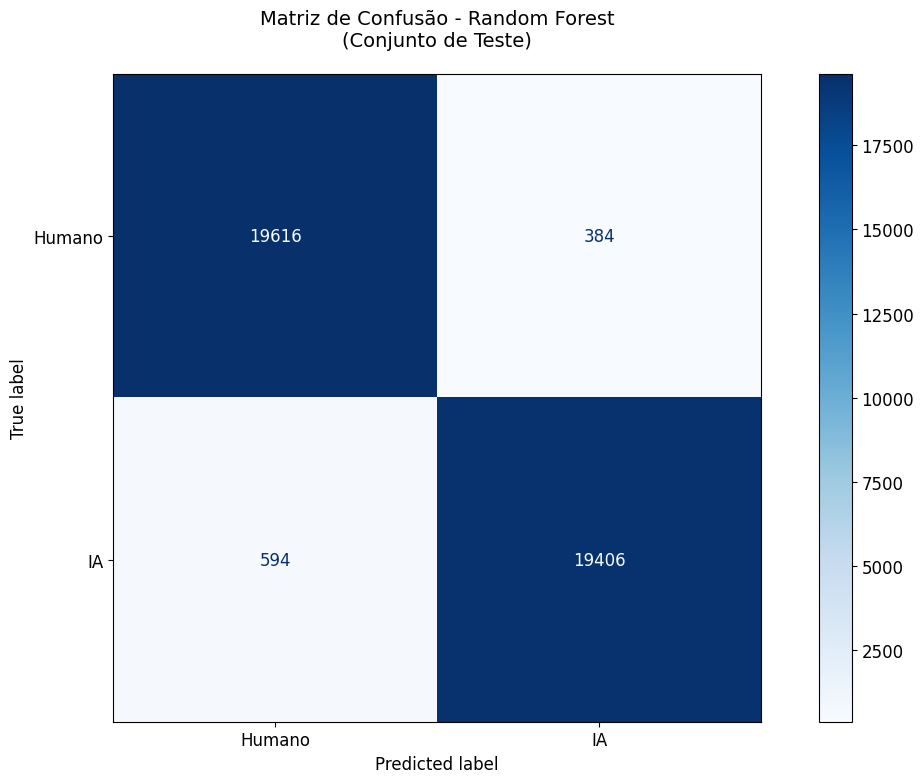

In [7]:
# ==================== 2. TREINAMENTO E MATRIZ DE CONFUSÃO ====================
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Treinar o modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calcular métricas finais
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"📈 Métricas no conjunto de teste:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🔍 MATRIZ DE CONFUSÃO:")
print(f"Verdadeiros Negativos (Humanos corretos): {tn}")
print(f"Falsos Positivos (Humanos → IA)        : {fp}")
print(f"Falsos Negativos (IA → Humanos)        : {fn}")
print(f"Verdadeiros Positivos (IA corretos)    : {tp}")

print(f"\n📊 TAXAS DE ERRO:")
print(f"Humanos classificados como IA: {(fp/(tn+fp))*100:.2f}%")
print(f"IA classificada como Humanos : {(fn/(tp+fn))*100:.2f}%")

# Plotar matriz de confusão
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Humano', 'IA'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Random Forest\n(Conjunto de Teste)', fontsize=14, pad=20)
plt.grid(False)
plt.tight_layout()
plt.show()


====🎯 ANÁLISE DE FEATURE IMPORTANCE (Mutual Information)====
Top Features por Mutual Information:
--------------------------------------------------
 1. structural_has_hashtag             : 0.307027
 2. structural_hashtag_density         : 0.294874
 3. syntactic_punct_ratio              : 0.293137
 4. lexical_word_length_variance       : 0.283829
 5. syntactic_pos_tag_entropy          : 0.227542
 6. https                              : 0.224396
 7. modi                               : 0.198775
 8. co                                 : 0.192944
 9. structural_has_url                 : 0.191751
10. https co                           : 0.188484
11. structural_url_density             : 0.185345
12. syntactic_pos_bigram_entropy       : 0.184484
13. structural_extra_spaces            : 0.169285
14. stylistic_capitalization_inconsistency: 0.166545
15. the                                : 0.139714
16. lexical_avg_word_length            : 0.138509
17. of                                 : 0.1383

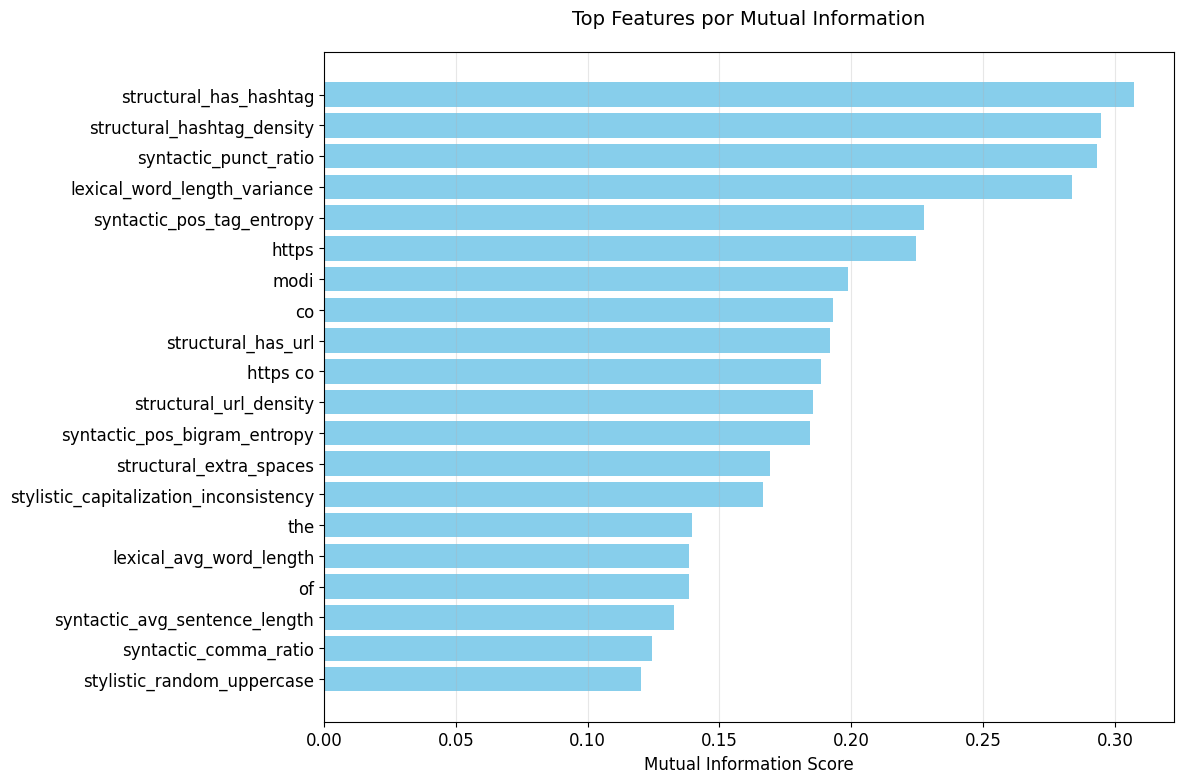


📋 IMPORTÂNCIA POR CATEGORIA (Mutual Information):
-------------------------------------------------------
Estruturais    : 1.5612 (7 features)
               └─ structural_has_hashtag: 0.307027
               └─ structural_hashtag_density: 0.294874
               └─ https: 0.224396
               └─ structural_has_url: 0.191751
               └─ https co: 0.188484
               └─ structural_url_density: 0.185345
               └─ structural_extra_spaces: 0.169285
Sintáticas     : 0.9623 (5 features)
               └─ syntactic_punct_ratio: 0.293137
               └─ syntactic_pos_tag_entropy: 0.227542
               └─ syntactic_pos_bigram_entropy: 0.184484
               └─ syntactic_avg_sentence_length: 0.132900
               └─ syntactic_comma_ratio: 0.124282
Léxicas        : 1.7043 (10 features)
               └─ lexical_word_length_variance: 0.283829
               └─ modi: 0.198775
               └─ co: 0.192944
               └─ https co: 0.188484
               └─ stylistic

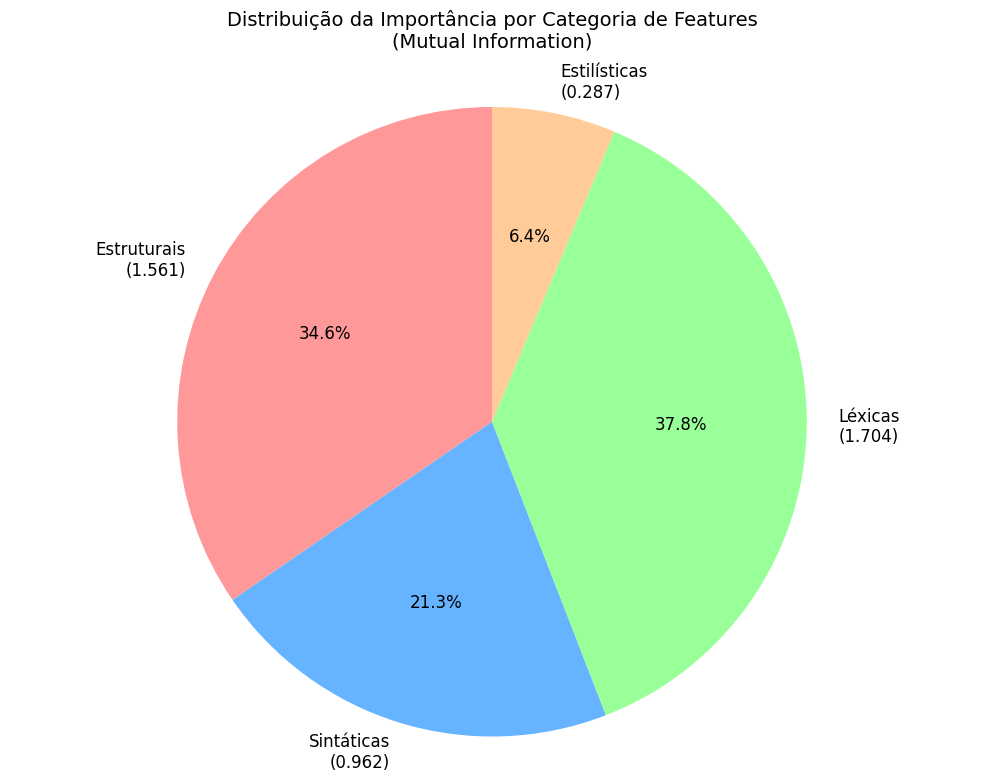


🔍 INSIGHTS DAS TOP FEATURES:
----------------------------------------
1. 🏆 structural_has_hashtag (0.307):
   → Presença de hashtags é o fator mais discriminativo
   → IA tende a usar menos hashtags que humanos

2. 📊 structural_hashtag_density (0.295):
   → Densidade de hashtags também muito importante
   → Humanos usam mais hashtags de forma natural

3. ⚙️  syntactic_punct_ratio (0.293):
   → Proporção de pontuação é key para detecção
   → IA tem padrões diferentes de pontuação

4. 📝 lexical_word_length_variance (0.284):
   → Variância no tamanho das palavras
   → Humanos têm mais variação no vocabulário

5. 🎯 syntactic_pos_tag_entropy (0.228):
   → Entropia das tags gramaticais (POS)
   → IA tem padrões mais previsíveis na gramática

6. 🌐 https (0.225):
   → Presença de links HTTPS
   → Humanos compartilham mais links que IA


In [ ]:
# ==================== 3. ANÁLISE DE FEATURE IMPORTANCE ====================
print("\n" + "🎯 ANÁLISE DE FEATURE IMPORTANCE (Mutual Information)".center(60, '='))


# Ordenar por importância (já deve estar ordenado, mas garantindo)
features_df = top_features.sort_values('mi_score', ascending=False)
features_df20 = top20_features.sort_values('mi_score', ascending=False)


print("Top Features por Mutual Information:")
print("-" * 50)
for i, row in features_df20.iterrows():
    print(f"{i+1:2d}. {row['feature']:35}: {row['mi_score']:.6f}")

# Visualizar as features
plt.figure(figsize=(12, 8))
plt.barh(features_df['feature'], features_df['mi_score'], color='skyblue')
plt.xlabel('Mutual Information Score', fontsize=12)
plt.title('Top Features por Mutual Information', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Análise por categorias baseada nas features do seu dataset
print("\n📋 IMPORTÂNCIA POR CATEGORIA (Mutual Information):")
print("-" * 55)

# Categorias adaptadas às suas features
categories = {
    'Estruturais': ['hashtag', 'url', 'http', 'https', 'structural', 'spaces'],
    'Sintáticas': ['syntactic', 'punct', 'pos', 'comma', 'sentence', 'entropy', 'bigram'],
    'Léxicas': ['lexical', 'word', 'length', 'avg', 'variance', 'the', 'of', 'modi', 'co'],
    'Estilísticas': ['stylistic', 'capitalization', 'uppercase', 'random', 'inconsistency']
}

category_importance = {}
for category, keywords in categories.items():
    # Encontrar features que contêm qualquer uma das keywords
    cat_features = []
    for feature in features_df['feature']:
        if any(keyword in feature for keyword in keywords):
            cat_features.append(feature)
    
    # Calcular importância total da categoria
    cat_importance = features_df[features_df['feature'].isin(cat_features)]['mi_score'].sum()
    category_importance[category] = {
        'importance': cat_importance,
        'count': len(cat_features),
        'features': cat_features,
        'avg_importance': cat_importance / len(cat_features) if cat_features else 0
    }
    
    # Exibir resultados
    if cat_features:
        print(f"{category:15}: {cat_importance:.4f} ({len(cat_features)} features)")
        for feat in cat_features:
            feat_score = features_df[features_df['feature'] == feat]['mi_score'].values[0]
            print(f"               └─ {feat}: {feat_score:.6f}")
    else:
        print(f"{category:15}: 0.0000 (0 features)")

# Gráfico de pizza por categoria
plt.figure(figsize=(10, 8))
sizes = [cat_info['importance'] for cat_info in category_importance.values()]
labels = [f"{cat}\n({size:.3f})" for cat, size in zip(category_importance.keys(), sizes)]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribuição da Importância por Categoria de Features\n(Mutual Information)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Análise detalhada das features mais importantes



====🎯 ANÁLISE DE FEATURE IMPORTANCE (Mutual Information)====
Top Features por Mutual Information:
--------------------------------------------------
 1. structural_has_hashtag             : 0.306283
 2. structural_hashtag_density         : 0.293101
 3. lexical_word_length_variance       : 0.284219
 4. https                              : 0.224484
 5. modi                               : 0.196380
 6. co                                 : 0.192403
 7. structural_has_url                 : 0.189975
 8. structural_url_density             : 0.187695
 9. https co                           : 0.187150
10. structural_extra_spaces            : 0.170186
11. stylistic_capitalization_inconsistency: 0.166811
12. complexity_long_sentences          : 0.166373
13. stylistic_capitalization_inconsistency.1: 0.164240
14. complexity_rare_words              : 0.159268
15. of                                 : 0.141397
16. lexical_avg_word_length            : 0.138703
17. the                                : 0

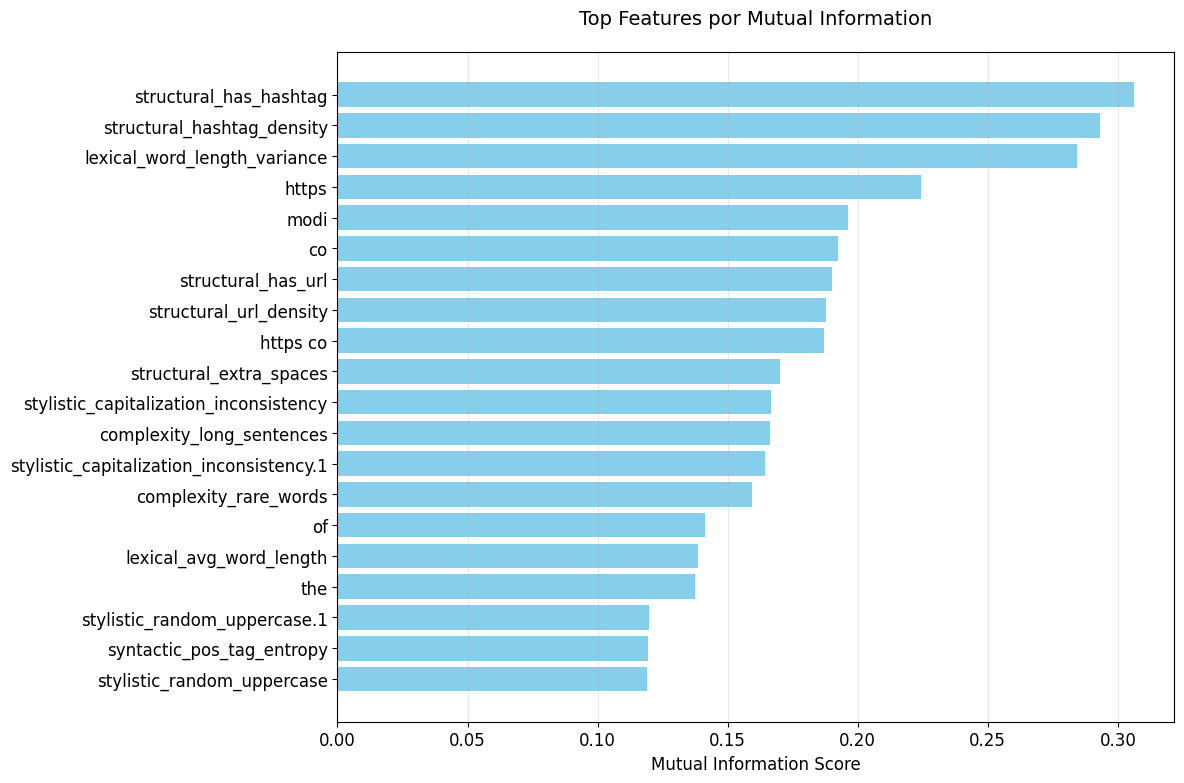


📋 IMPORTÂNCIA POR CATEGORIA (Mutual Information):
-------------------------------------------------------
Estruturais    : 1.5589 (17 features)
               └─ structural_has_hashtag: 0.306283
               └─ structural_hashtag_density: 0.293101
               └─ https: 0.224484
               └─ structural_has_url: 0.189975
               └─ structural_url_density: 0.187695
               └─ https co: 0.187150
               └─ structural_extra_spaces: 0.170186
               └─ structural_mention_density: 0.030554
               └─ structural_temporal_markers: 0.012505
               └─ change https: 0.008672
               └─ science https: 0.008329
               └─ science https co: 0.008214
               └─ climate change https: 0.008184
               └─ change https co: 0.007014
               └─ http: 0.003227
               └─ structural_has_mention: 0.002746
               └─ structural_is_retweet: 0.000000
Sintáticas     : 0.2856 (9 features)
               └─ complex

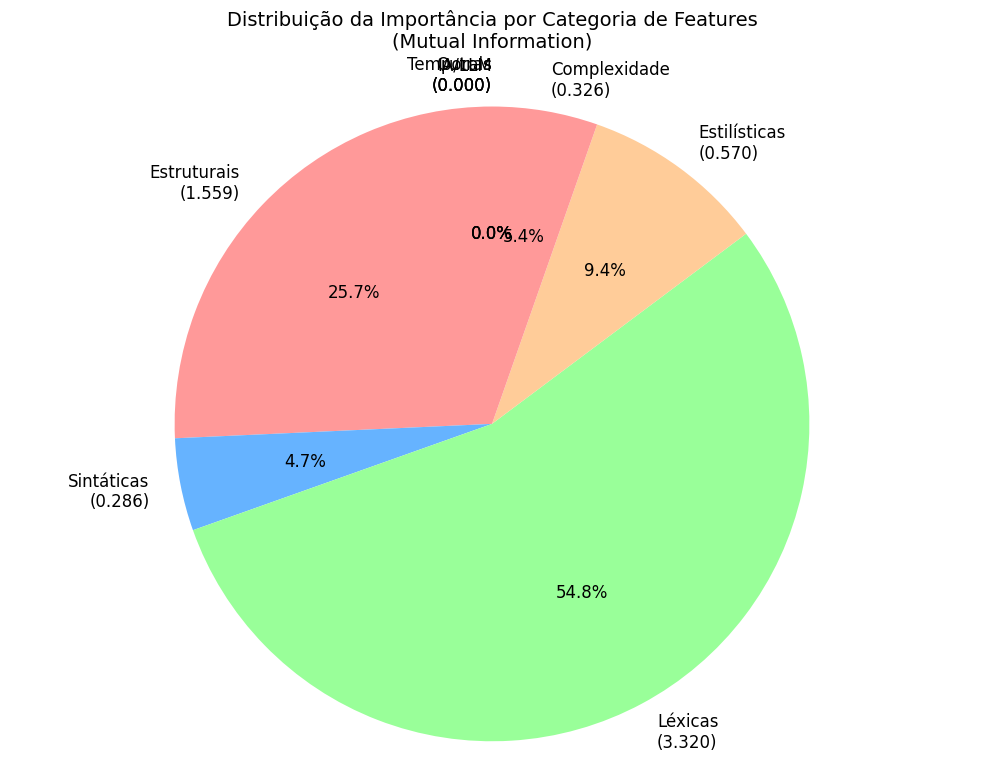

In [11]:
# ==================== 3. ANÁLISE DE FEATURE IMPORTANCE ====================
print("\n" + "🎯 ANÁLISE DE FEATURE IMPORTANCE (Mutual Information)".center(60, '='))


# Ordenar por importância (já deve estar ordenado, mas garantindo)
features_df = top_features.sort_values('mi_score', ascending=False)
features_df20 = top20_features.sort_values('mi_score', ascending=False)


print("Top Features por Mutual Information:")
print("-" * 50)
for i, row in features_df20.iterrows():
    print(f"{i+1:2d}. {row['feature']:35}: {row['mi_score']:.6f}")

# Visualizar as features
plt.figure(figsize=(12, 8))
plt.barh(features_df20['feature'], features_df20['mi_score'], color='skyblue')
plt.xlabel('Mutual Information Score', fontsize=12)
plt.title('Top Features por Mutual Information', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Análise por categorias baseada nas features do seu dataset
print("\n📋 IMPORTÂNCIA POR CATEGORIA (Mutual Information):")
print("-" * 55)

# Categorias adaptadas às suas features
categories = {
'Estruturais': ['hashtag', 'url', 'http', 'https', 'structural', 'spaces', 'mention', 'temporal_markers', 'is_retweet'],
'Sintáticas': ['syntactic', 'punct', 'pos', 'comma', 'sentence', 'entropy', 'bigram', 'subordinating'],
'Léxicas': ['lexical', 'word', 'length', 'avg', 'variance', 'the', 'of', 'modi', 'co', 'stopword', 'type_token', 'unique_words',
# N-grams (palavras únicas, bigramas, trigramas)
'is', 'in', 'to', 'we', 'on', 'us', 'by', 'and', 'has', 'as', 'be', 'an', 'it', 'been', 'll', 'do', 'he', 'that', 'at',
'for', 'you', 'are', 'did', 're', 'from', 'never', 'about', 'me', 'like', 'him', 'over', 'only', 'my', 'too', 'then', 'got',
'more', 'who', 'just', 'can', 'even', 'with', 'will', 'your', 'few', 'could', 'or', 'two', 'real', 'read', 'how', 'done',
'know', 'make', 'this', 'year', 'their', 'much', 'many', 'there', 'next', 'long', 'than', 'was', 'think', 'way', 'here',
'should', 'his', 'say', 'well', 'some', 'but', 'off', 'such', 'would', 'had', 've', 'go', 'being', 'thanks', 'people',
'they', 'stop', 'one', 'not', 'years', 'what', 'now', 'every', 'said', 'right', 'have', 'when', 'must', 'via', 'its',
'still', 'may', 'work', 'support', 'need', 'life', 'home', 'were', 'because', 'which', 'other', 'made', 'she', 'any',
'going', 'says', 'want', 'them', 'so', 'under', 'up', 'do', 'day', 'get', 'where', 'her', 'very', 'getting', 'week',
'out', 'vote', 'man', 'come', 'news', 'already', 'all', 'media', 'last', 'win', 'while', 'working', 'back', 'after',
'also', 'am', 'into', 'please', 'no', 'great', 'take', 'see', 'since', 'ever', 'those', 'does', 'down', 'before', 'time',
'big', 'ca', 'today', 'use', 'love', 'money', 'good', 'poor', 'number', 'shows', 'fight', 'team', 'technology', 'space',
'give', 'quot', 'really', 'if', 'nation', 'indian', 'state', 'election', 'help', 'action', 'doing', 'most', 'need to',
'amp', 'why', 'important', 'national', 'future', 'power', 'minister', 'live', 'best', 'government', 'country', 'world',
# Bigramas e trigramas específicos
'in the', 'of the', 'the us', 'has been', 'do nt', 'on the', 'that the', 'you are', 'more than', 'to get', 'if you',
'it is', 'for the', 'to be', 'we are', 'is not', 'we re', 'the first', 'from the', 'will be', 'have been', 'about the',
'and the', 'to the', 'the country', 'going to', 'the world', 'new study', 'on climate', 'is the', 'this is', 'change is',
'climate change is', 'on climate change', 'change and', 'of covid', 'of climate', 'science of', 'the science', 'the covid19',
'the trump', 'trump administration', 'the trump administration', 'vaccination', 'administration is', 'trump administration is',
'change https', 'science https', 'science https co', 'climate change https', 'change https co', 'climate change and',
'trump campaign', 'the uk', 'election2020', 'covid 19', 'narendra modi', 'donaldtrump', 'joebiden', 'rahul', 'modis',
'bjp', 'covid19', 'vaccine', 'pandemic', 'health', 'congress', 'govt', 'engineering', 'global', 'report', 'campaign',
'cases', 'uk', 'study', 'india', 'narendra', 'change', 'climate', 'science', 'covid', 'trump', 'biden', 'ai', 'climate change'],
'Estilísticas': ['stylistic', 'capitalization', 'uppercase', 'random', 'inconsistency', 'exclamation', 'ellipsis', 'repeated', 'emoji', 'question', 'emoticon', 'repeated_chars', 'repeated_words'],
'Complexidade': ['complexity', 'long_sentences', 'rare_words', 'syntactic_depth', 'subordinating_ratio'],
'Temporais': ['temporal', 'future_ratio', 'recent_ratio', 'past_ratio'],
'IA/LLM': ['ai_', 'llm_', 'perplexity', 'chatgpt', 'hedging', 'safety_disclaimers', 'repeated_ngrams', 'disclaimer_density', 'structured_output', 'ai_topic_shifts', 'ai_perplexity_score', 'llm_chatgpt_patterns', 'ai_hedging_language', 'llm_structured_output', 'llm_overly_polite', 'ai_safety_disclaimers', 'ai_repeated_ngrams', 'llm_disclaimer_density'],
'Outras': [] # Categoria para features não classificadas
}

category_importance = {}
for category, keywords in categories.items():
    # Encontrar features que contêm qualquer uma das keywords
    cat_features = []
    for feature in features_df['feature']:
        if any(keyword in feature for keyword in keywords):
            cat_features.append(feature)
    
    # Calcular importância total da categoria
    cat_importance = features_df20[features_df20['feature'].isin(cat_features)]['mi_score'].sum()
    category_importance[category] = {
        'importance': cat_importance,
        'count': len(cat_features),
        'features': cat_features,
        'avg_importance': cat_importance / len(cat_features) if cat_features else 0
    }
    
    # Exibir resultados
    if cat_features:
        print(f"{category:15}: {cat_importance:.4f} ({len(cat_features)} features)")
        for feat in cat_features:
            feat_score = features_df[features_df['feature'] == feat]['mi_score'].values[0]
            print(f"               └─ {feat}: {feat_score:.6f}")
    else:
        print(f"{category:15}: 0.0000 (0 features)")

# Gráfico de pizza por categoria
plt.figure(figsize=(10, 8))
sizes = [cat_info['importance'] for cat_info in category_importance.values()]
labels = [f"{cat}\n({size:.3f})" for cat, size in zip(category_importance.keys(), sizes)]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribuição da Importância por Categoria de Features\n(Mutual Information)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Análise detalhada das features mais importantes


In [9]:
# ==================== 1. VALIDAÇÃO CRUZADA ====================
# Definindo o modelo CORRETAMENTE para Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(
    random_state=42,    
    max_iter=1000,     
    n_jobs=-1           
)

# Definindo métricas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Validação cruzada
results = cross_validate(clf, X, y, cv=5, scoring=scoring, n_jobs=-1)

# Exibindo resultados
print("\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA (Logistic Regression):")
print("-" * 55)
for metric in scoring.keys():
    mean_score = np.mean(results['test_' + metric])
    std_score = np.std(results['test_' + metric])
    print(f"{metric:12}: {mean_score:.4f} ± {std_score:.4f}")


📊 RESULTADOS DA VALIDAÇÃO CRUZADA (Logistic Regression):
-------------------------------------------------------
accuracy    : 0.9469 ± 0.0292
precision   : 0.9550 ± 0.0313
recall      : 0.9385 ± 0.0392
f1          : 0.9463 ± 0.0296
roc_auc     : 0.9469 ± 0.0292


📈 Métricas no conjunto de teste:
Accuracy : 0.9547
Precision: 0.9627
Recall   : 0.9460
F1-Score : 0.9543
ROC-AUC  : 0.9911

🔍 MATRIZ DE CONFUSÃO:
Verdadeiros Negativos (Humanos corretos): 19267
Falsos Positivos (Humanos → IA)        : 733
Falsos Negativos (IA → Humanos)        : 1080
Verdadeiros Positivos (IA corretos)    : 18920

📊 TAXAS DE ERRO:
Humanos classificados como IA: 3.67%
IA classificada como Humanos : 5.40%


<Figure size 1000x800 with 0 Axes>

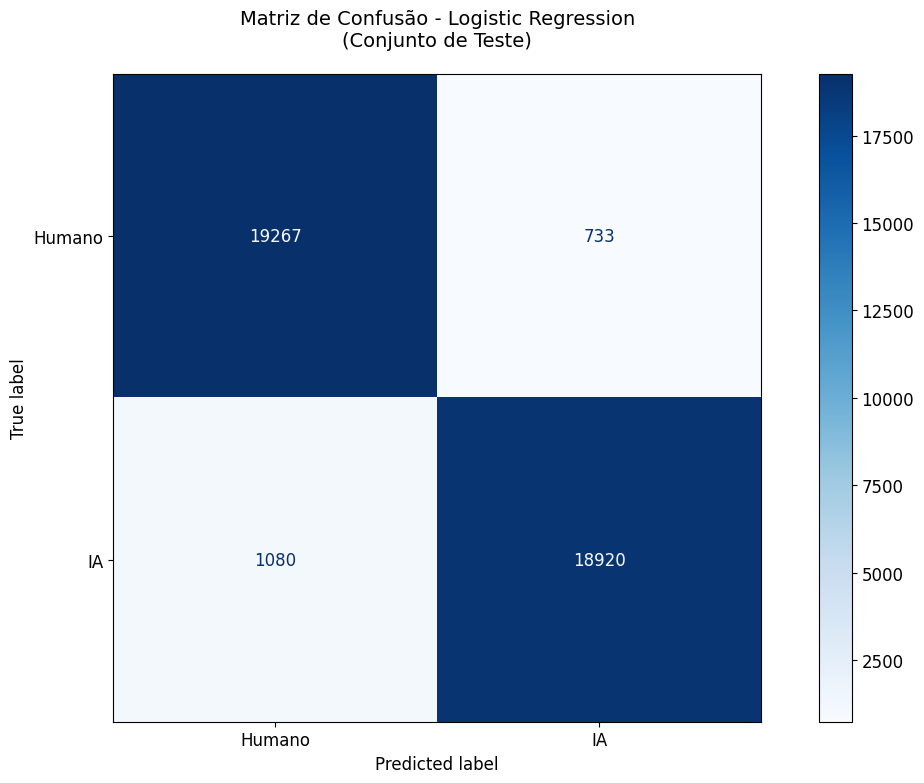

In [10]:
# ==================== 2. TREINAMENTO E MATRIZ DE CONFUSÃO ====================
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Treinar o modelo
rf_model = LogisticRegression(
    random_state=42,    
    max_iter=1000,     
    n_jobs=-1           
)
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calcular métricas finais
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"📈 Métricas no conjunto de teste:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🔍 MATRIZ DE CONFUSÃO:")
print(f"Verdadeiros Negativos (Humanos corretos): {tn}")
print(f"Falsos Positivos (Humanos → IA)        : {fp}")
print(f"Falsos Negativos (IA → Humanos)        : {fn}")
print(f"Verdadeiros Positivos (IA corretos)    : {tp}")

print(f"\n📊 TAXAS DE ERRO:")
print(f"Humanos classificados como IA: {(fp/(tn+fp))*100:.2f}%")
print(f"IA classificada como Humanos : {(fn/(tp+fn))*100:.2f}%")

# Plotar matriz de confusão
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Humano', 'IA'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Logistic Regression\n(Conjunto de Teste)', fontsize=14, pad=20)
plt.grid(False)
plt.tight_layout()
plt.show()

In [11]:
# ==================== 1. VALIDAÇÃO CRUZADA (SVM) ====================
from sklearn.svm import SVC

# Definindo o modelo SVM CORRETAMENTE
clf = SVC(
    random_state=42,
    kernel='rbf',        # Kernel radial basis function (padrão)
    probability=True,    # Necessário para roc_auc_score
    max_iter=1000        # Número máximo de iterações
    # SVM não tem parâmetro n_jobs
)

# Definindo métricas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Validação cruzada
results = cross_validate(clf, X, y, cv=5, scoring=scoring, n_jobs=-1)

# Exibindo resultados
print("\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA (SVM):")
print("-" * 45)
for metric in scoring.keys():
    mean_score = np.mean(results['test_' + metric])
    std_score = np.std(results['test_' + metric])
    print(f"{metric:12}: {mean_score:.4f} ± {std_score:.4f}")

/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warning


📊 RESULTADOS DA VALIDAÇÃO CRUZADA (SVM):
---------------------------------------------
accuracy    : 0.3720 ± 0.0416
precision   : 0.4217 ± 0.0278
recall      : 0.7068 ± 0.0923
f1          : 0.5277 ± 0.0468
roc_auc     : 0.3720 ± 0.0416


📈 Métricas no conjunto de teste:
Accuracy : 0.3775
Precision: 0.4277
Recall   : 0.7252
F1-Score : 0.5381
ROC-AUC  : 0.4988

🔍 MATRIZ DE CONFUSÃO:
Verdadeiros Negativos (Humanos corretos): 595
Falsos Positivos (Humanos → IA)        : 19405
Falsos Negativos (IA → Humanos)        : 5496
Verdadeiros Positivos (IA corretos)    : 14504

📊 TAXAS DE ERRO:
Humanos classificados como IA: 97.02%
IA classificada como Humanos : 27.48%


<Figure size 1000x800 with 0 Axes>

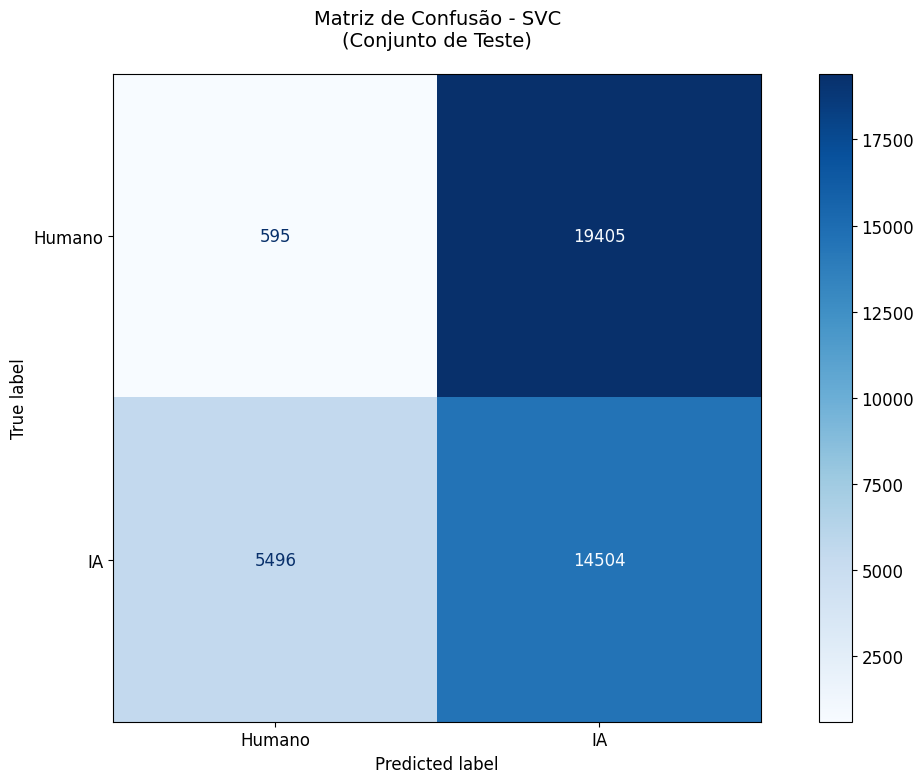

In [12]:
# ==================== 2. TREINAMENTO E MATRIZ DE CONFUSÃO ====================
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Treinar o modelo
rf_model = SVC(
    random_state=42,
    kernel='rbf',        # Kernel radial basis function (padrão)
    probability=True,    # Necessário para roc_auc_score
    max_iter=1000        # Número máximo de iterações
    # SVM não tem parâmetro n_jobs
)
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calcular métricas finais
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"📈 Métricas no conjunto de teste:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🔍 MATRIZ DE CONFUSÃO:")
print(f"Verdadeiros Negativos (Humanos corretos): {tn}")
print(f"Falsos Positivos (Humanos → IA)        : {fp}")
print(f"Falsos Negativos (IA → Humanos)        : {fn}")
print(f"Verdadeiros Positivos (IA corretos)    : {tp}")

print(f"\n📊 TAXAS DE ERRO:")
print(f"Humanos classificados como IA: {(fp/(tn+fp))*100:.2f}%")
print(f"IA classificada como Humanos : {(fn/(tp+fn))*100:.2f}%")

# Plotar matriz de confusão
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Humano', 'IA'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - SVC\n(Conjunto de Teste)', fontsize=14, pad=20)
plt.grid(False)
plt.tight_layout()
plt.show()